### Setting Up
Prepare the environment by loading in the libraries and importing datasets.

In [4]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn xgboost imblearn| grep -v 'already satisfied'

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For setting seed
import random

# Imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.impute import IterativeImputer
# Inbalanced data oversampling
from imblearn.over_sampling import SMOTE

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Dataset splitting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve, StratifiedShuffleSplit, RandomizedSearchCV, StratifiedKFold, ShuffleSplit, GridSearchCV

# Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler

# Model evaluation metric MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score

# Important features library
import xgboost as xgb
from xgboost import plot_importance

# Counter
from collections import Counter

# Model Evaluation
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report

# Pipeline Configuration
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Load the data
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

### Exploratory Data Analysis
Findings:

In [12]:
# Display the first few rows of the training dataset
print(train_data.head())

# Get the summary statistics of the training dataset
print(train_data.describe())

# Check for missing values in the training dataset
print(train_data.isnull().sum())

   id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8  ...       V21       V22       V23       V24       V25  \
0  0.110697 -0.263477  ... -0.334701 -0.887840  0.336701 -0.110835 -0.291459   
1 -1.029289  0.050198  ...  0.054848 -0.038367  0.133518 -0.461928 -0.465491   
2  0.948146 -0.084789  ... -0.326725 -0.803736  0.154495  0.951233 -0.506919   
3 -0.087826 -0.035367  ... -0.095514 -0.079792  0.167701 -0.042939  0.000799   
4 -0.938651  0.569239  ...  0.099157  0.608908  0.027901 -0.262813  0.257834   

        V26       V27       V28  Amount  Class  
0  0.207733 -0.0765

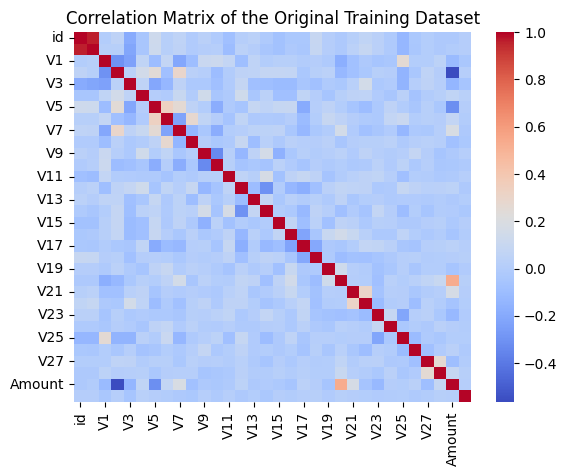

In [4]:
# Calculate and visualize the correlations between features
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of the Original Training Dataset')
plt.show()

### Further Data Exploration

C:\Users\44771\AppData\Local\Temp\ipykernel_23388\2596155953.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(amount_variable, ax=ax[0], color='blue')
C:\Users\44771\AppData\Local\Temp\ipykernel_23388\2596155953.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_variable, ax=ax[1], col

(0.0, 120580.0)

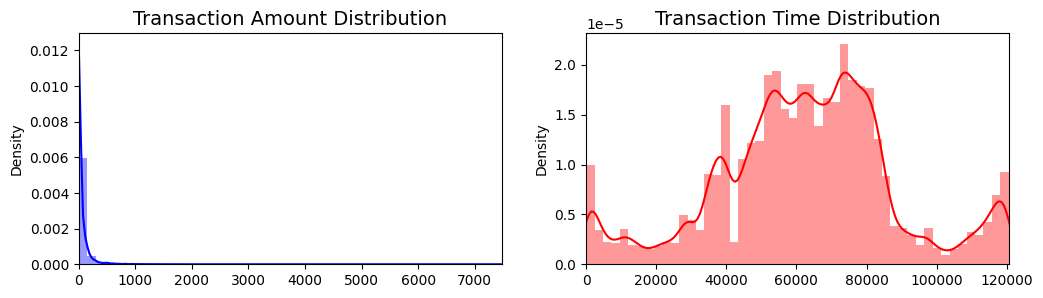

In [10]:
# Set figure and axes size
fig, ax = plt.subplots(1, 2, figsize=(12,3))

# Extract the values from the Amount and Time columns
amount_variable = train_data['Amount'].values
time_variable = train_data['Time'].values

# Plot the Distributions of the two variables
sns.distplot(amount_variable, ax=ax[0], color='blue')
# Set plot title
ax[0].set_title('Transaction Amount Distribution', fontsize=14)
# Set x axis limitations
ax[0].set_xlim([min(amount_variable), max(amount_variable)])

sns.distplot(time_variable, ax=ax[1], color='red')
ax[1].set_title('Transaction Time Distribution', fontsize=14)
ax[1].set_xlim([min(time_variable), max(time_variable)])

### Distribution of Target Variable
The current training dataset exhibits extreme class imbalance, where only 0.21% of the cases are classified as fraudulent and the remaining 99.79% are non-fraudulent. Using this dataset for predictive models may lead to inaccurate analysis results, as the models may assume that most transactions are genuine, which could result in biased predictions. The objective of this study is to identify patterns accurately. Correlations between variables might also be incorrect if the data fitted is imbalanced.

(-1.1003361923856179,
 1.0996638071065905,
 -1.152498813078573,
 1.102499943479932)

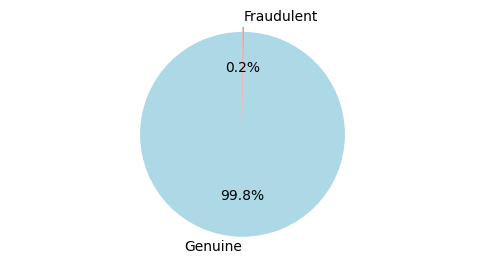

In [6]:
# Compute the distribution of the target variable (Class)
genuine_count = train_data['Class'].value_counts()[0]
fraudulent_count = train_data['Class'].value_counts()[1]

# Visualize the distribution of the target variable (Class)
plt.figure(figsize=(6, 3))
labels = ['Genuine', 'Fraudulent']
sizes = [genuine_count, fraudulent_count]
colors = ['lightblue', 'salmon']
# explode the first slice
explode = (0.05, 0)  
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
#plt.title('Distribution of Target Variable')

### Imputation

In [16]:
# Create a copy of the training dataset
train_data_missing = train_data.copy()

# Remove  remove a small randomly selected proportion of the data values (e.g., 5%)
missing_fraction = 0.05
random.seed(42)
for col in train_data_missing.columns:
    if col != 'Class':
        missing_indices = train_data_missing.sample(frac=missing_fraction, random_state=42).index
        train_data_missing.loc[missing_indices, col] = np.nan

In [9]:
# Create object for scores
msd_scores = {}

# Try K-values
for k in range(2, 11, 2):
    knn_imputer = KNNImputer(n_neighbors=k)
    imputed_data = knn_imputer.fit_transform(train_data_missing)
    imputed_data_df = pd.DataFrame(imputed_data, columns=train_data_missing.columns)

    # Compute the mean squared error between imputed values and original values
    msd = mean_squared_error(imputed_data_df, train_data)
    msd_scores[k] = msd

# Find the k with the lowest mean squared difference
best_k = min(msd_scores, key=msd_scores.get)
print(f'Optimal k value: {best_k}')

Optimal k value: 6


In [10]:
# Define the imputation methods
imputation_methods = {
    'Mean Imputation': SimpleImputer(strategy='mean'),
    'Iterative Imputer': IterativeImputer(random_state=42),
    'KNN Imputation': KNNImputer(n_neighbors=6),
}

# Create missing values list
missing = train_data_missing.isna()

# Evaluate the imputation methods
for method_name, imputer in imputation_methods.items():
    imputed_data = imputer.fit_transform(train_data_missing)
    imputed_data_df = pd.DataFrame(imputed_data, columns=train_data_missing.columns)

    # Compute the RMSE and MAE between imputed values and original values
    mse_errors = []
    mae_errors = []
    for column in train_data.columns:
        column_miss = missing[column]
        if column_miss.any():
            mse_error = mean_squared_error(train_data.loc[column_miss, column], imputed_data_df.loc[column_miss, column], squared=False)
            mae_error = mean_absolute_error(train_data.loc[column_miss, column], imputed_data_df.loc[column_miss, column])
            mse_errors.append(mse_error)
            mae_errors.append(mae_error)

    rmse = np.mean(mse_errors)
    mae = np.mean(mae_errors)

    print(f'{method_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}')

Mean Imputation - RMSE: 2885.86, MAE: 2415.53
Iterative Imputer - RMSE: 2885.80, MAE: 2415.47
KNN Imputation - RMSE: 3255.40, MAE: 2649.80


### Outliers

In [8]:
### Function to detect outliers in the data
#   INPUTS:
#   - data: pandas DataFrame
#    - columns: list of column names (strings)
#    - factor: factor to multiply the IQR by to determine the outlier threshold (default=2)
    
#    OUTPUT:
#    - outlier_indices: numpy array of indices of the rows that contain outliers in any of the columns
def detect_outliers_iqr(data, columns, factor=2):
    # Object for outlier indices
    outlier_indices = []
    
    for col in columns:
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Identify Outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index
        
        # Add outlier indices to lisr
        outlier_indices.extend(outliers)
    
    return np.unique(outlier_indices)


# Select only numeric columns
numeric_data = train_data.select_dtypes(include=[np.number])

# Get outlier indices
outlier_indices = detect_outliers_iqr(train_data, numeric_data)

# Print the number of outliers detected and their indices
print(f"Number of outliers detected: {len(outlier_indices)}")
print(f"Outlier indices: {outlier_indices}")

# Create a new dataset without outliers
train_data_no_outliers = train_data.drop(outlier_indices).reset_index(drop=True)

Number of outliers detected: 69104
Outlier indices: [     7     12     14 ... 219126 219127 219128]


### Outliers should be left in as they are the fraudulent cases

Dimensions of Train Data (No Outliers): 150025 rows, 32 columns
Class=1 rows in Train Data (No Outliers): False


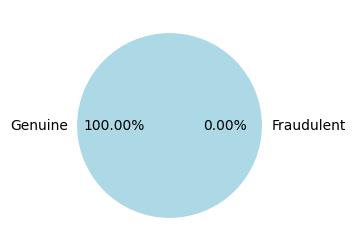

In [9]:
# Compute the distribution of the target variable (Class)
genuine_count = train_data_no_outliers['Class'].value_counts().get(0, 0)
fraudulent_count = train_data_no_outliers['Class'].value_counts().get(1, 0)

# Visualize the distribution of the target variable (Class)
plt.figure(figsize=(5, 3))
plt.pie([genuine_count, fraudulent_count], labels=['Genuine', 'Fraudulent'], colors=['lightblue', 'red'], autopct='%1.2f%%')
#plt.title('Distribution of Target Variable')

# Print some information about the data
print(f"Dimensions of Train Data (No Outliers): {train_data_no_outliers.shape[0]} rows, {train_data_no_outliers.shape[1]} columns")
print(f"Class=1 rows in Train Data (No Outliers): {fraudulent_count > 0}")

### How to Scale the  Data
Variables Amount and Time have not been scaled yet and should be to match the rest of the data. However, as we are not sure if the other variables were scaled before the PCA was performed, we decided to scale the whole data set. First visualise the outliers to decide on the scaling method.

count    219129.000000
mean      62377.415376
std       25620.348569
min           0.000000
25%       47933.000000
50%       63189.000000
75%       77519.000000
max      120580.000000
Name: Time, dtype: float64


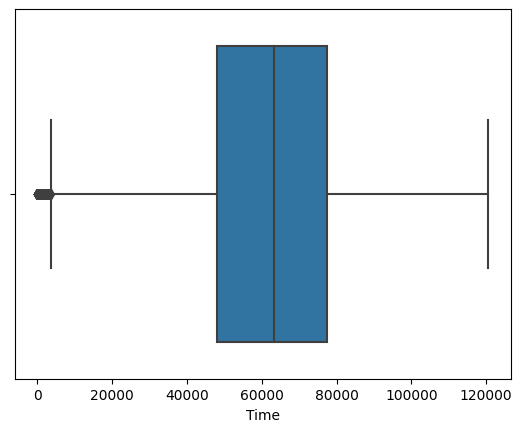

In [10]:
# Check for outliers to then decide which scaling method to use
# Plot Time outliers
sns.boxplot(x=train_data['Time'])
# Check the summary
print(train_data['Time'].describe())

count    219129.000000
mean         66.359803
std         150.795017
min           0.000000
25%           5.990000
50%          21.900000
75%          68.930000
max        7475.000000
Name: Amount, dtype: float64


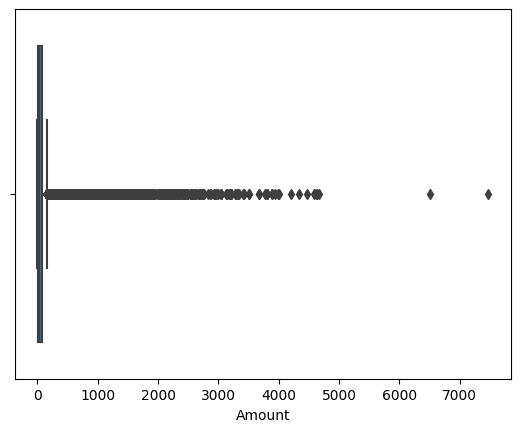

In [11]:
# Plot Amount outliers
sns.boxplot(x=train_data['Amount'])
# Check the summary
print(train_data['Amount'].describe())
# Amount has extreme outliers

### XGBOOST

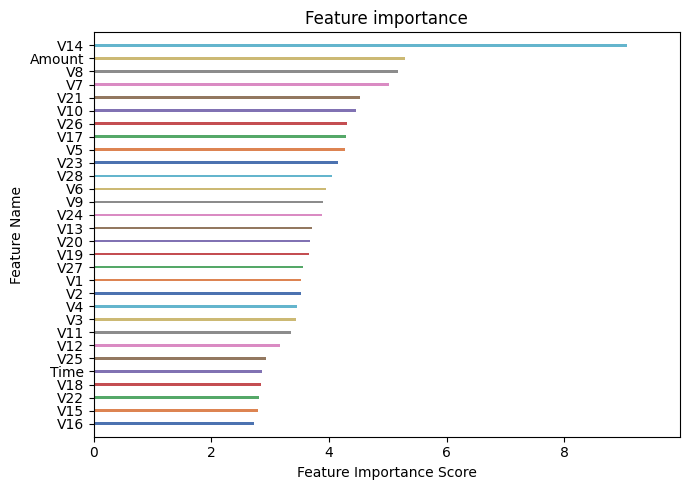

In [11]:
# Split the data into explanatory and prediction variables
X_balanced = train_data.drop(['Class','id'], axis=1)
y_balanced = train_data['Class']
features = X_balanced.columns.to_list()

# Convert the training data into a distance matrix
dtrain = xgb.DMatrix(X_balanced, label=y_balanced, feature_names = features)

# Train XGBoost classifier
params = {'objective': 'binary:logistic', 'seed': 42}
xgb_model = xgb.train(params, dtrain)
 
# Set colours
colours = sns.color_palette('deep', n_colors=10)

# Visualize feature importances with improved aesthetics and custom color palette
fig, ax = plt.subplots(figsize=(7, 5))
plot_importance(xgb_model, ax=ax, importance_type='gain', show_values=False, 
                xlabel='Feature Importance Score',
                ylabel='Feature Name', grid=False, color=colours)
plt.tight_layout()

### Balanced Subsample Dataset - Random Undersampling   
When training a machine learning model on an imbalanced dataset with limited instances of the fraudulent class, the resulting performance may be inadequate. The model may underperform in terms of predictive accuracy, which is the aim of this study. To address this issue, random undersampling is employed. The drawback of this method is that the information loss may lead to decreased prediction performance.


Genuine 50.0 % of the dataset
Fraudulent 50.0 % of the dataset


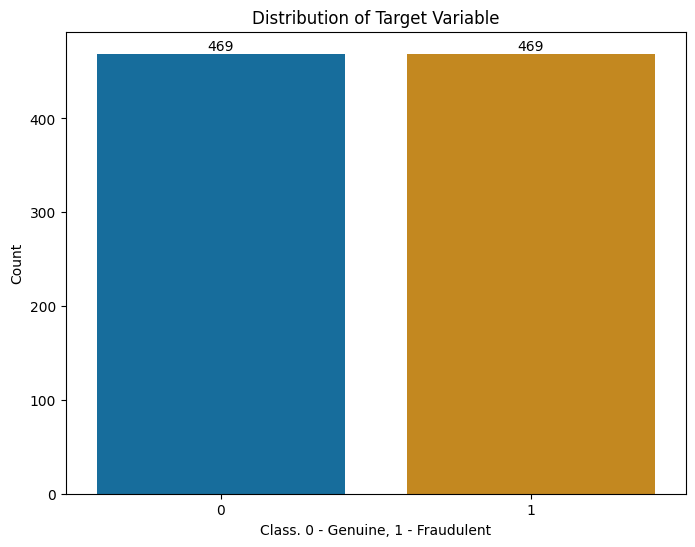

In [12]:
# Define a function for random undersampling
def random_undersample(df):
    # Separate the data by Class
    class_0_data = df[df['Class'] == 0]
    class_1_data = df[df['Class'] == 1]

    # Create 50/50 split
    n_samples = min(len(class_0_data), len(class_1_data))

    # Randomly select n_samples from each class
    class_0_sample = class_0_data.sample(n=n_samples, random_state=42)
    class_1_sample = class_1_data.sample(n=n_samples, random_state=42)

    # Combine samples from both classes 
    balanced_data = pd.concat([class_0_sample, class_1_sample], axis=0)

    # Shuffle data
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_data

undersample_train_data = random_undersample(train_data)

# Compute the distribution of the target variable in the Random Undersampled data set
print('Genuine', round(undersample_train_data['Class'].value_counts()[0]/len(undersample_train_data) * 100,2), '% of the dataset')
print('Fraudulent', round(undersample_train_data['Class'].value_counts()[1]/len(undersample_train_data) * 100,2), '% of the dataset')

# Visualize the distribution of the target variable (Class)
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=undersample_train_data, palette='colorblind')
# Add titles to the plot
plt.title('Distribution of Target Variable')
plt.xlabel('Class. 0 - Genuine, 1 - Fraudulent')
plt.ylabel('Count')
# Compute the counts of Classes
for i in range(undersample_train_data['Class'].nunique()):
    count = undersample_train_data['Class'].value_counts().values[i]
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')
plt.show()

### Undersampled Data Evaluation

Recall is better than from the SMOTE dataset. However, precision is not amazing.

In [13]:
# Split the train_data into X_train and y_train
X_train_u = train_data.drop('Class', axis=1)
y_train_u = train_data['Class']

# Define the pipelines for undersampled data evaluation
pipeline = ImbPipeline([
    ('sampling', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression())
])

# Split the data into training and testing sets
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_train_u, y_train_u, test_size=0.3, random_state=42)

# Fit the pipeline on the training set
pipeline.fit(X_train_u, y_train_u)

# Make predictions on the testing set
y_pred_u = pipeline.predict(X_test_u)

# Print the classification report
print(classification_report(y_test_u, y_pred_u))

# Compute and print evaluation metrics
acc = accuracy_score(y_test_u, y_pred_u)
prec = precision_score(y_test_u, y_pred_u)
rec = recall_score(y_test_u, y_pred_u)
f1 = f1_score(y_test_u, y_pred_u)
roc_auc = roc_auc_score(y_test_u, y_pred_u)

# Print the evaluation results
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)
print('AUC-ROC score:', roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.54      0.70     65593
           1       0.00      0.60      0.01       146

    accuracy                           0.54     65739
   macro avg       0.50      0.57      0.35     65739
weighted avg       1.00      0.54      0.70     65739

Accuracy: 0.5360288413270661
Precision: 0.002849749418585607
Recall: 0.5958904109589042
F1-score: 0.005672371638141809
AUC-ROC score: 0.565893004787305


### Correlation in Balanced Undersampled Data

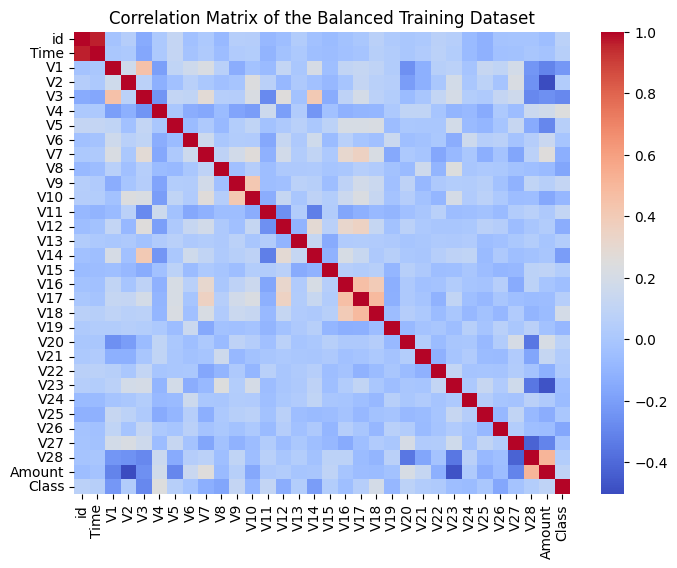

Variables with absolute correlation of 0.35 or higher:
     Variable 1 Variable 2  Correlation Score
32         Time         id           0.961781
35       Amount        V28           0.511816
37          V17        V18           0.488694
39          V16        V17           0.460834
40           V1         V3           0.449380
43          V10         V9           0.417806
44          V14         V3           0.407379
47          V16        V18           0.400652
49          V17         V7           0.357196
1015        V20        V28           0.350497
1017        V23        V28           0.350917
1019        V27        V28           0.425192
1021     Amount        V23           0.475607
1023     Amount         V2           0.502595


In [14]:
# Calculate the correlations between features
corr_matrix_b = undersample_train_data.corr()
# Visualise the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_b, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of the Balanced Training Dataset')
plt.show()

# Find the absolute correlations that are 0.35 or higher
high_corr_vars = pd.DataFrame(np.abs(corr_matrix_b.unstack().sort_values(ascending=False)), columns=['Correlation Score']).reset_index()
high_corr_vars.columns = ['Variable 1', 'Variable 2', 'Correlation Score']
high_corr_vars = high_corr_vars[high_corr_vars['Correlation Score'] >= 0.35]
high_corr_vars = high_corr_vars[high_corr_vars['Variable 1'] < high_corr_vars['Variable 2']]

# Print the variables with high correlation
print("Variables with absolute correlation of 0.35 or higher:")
print(high_corr_vars)

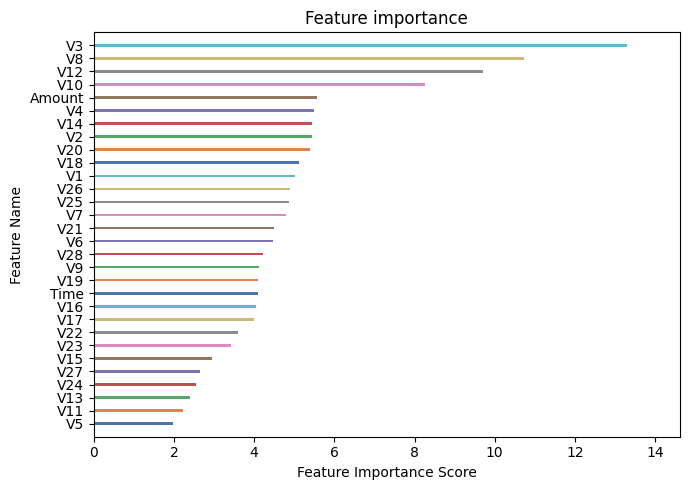

In [15]:
# Split the data into explanatory and prediction variables
X_balanced = undersample_train_data.drop(['Class','id'], axis=1)
y_balanced = undersample_train_data['Class']
features = X_balanced.columns.to_list()

# Convert the training data into a distance matrix
dtrain = xgb.DMatrix(X_balanced, label=y_balanced, feature_names = features)

# Train XGBoost classifier
params = {'objective': 'binary:logistic', 'seed': 42}
xgb_model = xgb.train(params, dtrain)
 
# Set colours
colours = sns.color_palette('deep', n_colors=10)

# Visualize feature importances with improved aesthetics and custom color palette
fig, ax = plt.subplots(figsize=(7, 5))
plot_importance(xgb_model, ax=ax, importance_type='gain', show_values=False, 
                xlabel='Feature Importance Score',
                ylabel='Feature Name', grid=False, color=colours)
plt.tight_layout()

### Explore the variables that are correlated with "Class"

Correlation between features and target variable
        Correlation Score
id               0.076733
Time             0.060823
V1              -0.232354
V2               0.032260
V3              -0.287168
V4               0.248518
V5               0.059575
V6              -0.011941
V7              -0.131925
V8              -0.168995
V9               0.116484
V10             -0.091656
V11              0.112809
V12             -0.136617
V13              0.040695
V14             -0.205495
V15              0.039920
V16             -0.049883
V17              0.054025
V18              0.195429
V19             -0.090974
V20              0.079610
V21              0.036036
V22              0.019825
V23             -0.055240
V24             -0.068205
V25             -0.002292
V26             -0.164238
V27             -0.022223
V28              0.038424
Amount           0.091677
Class            1.000000


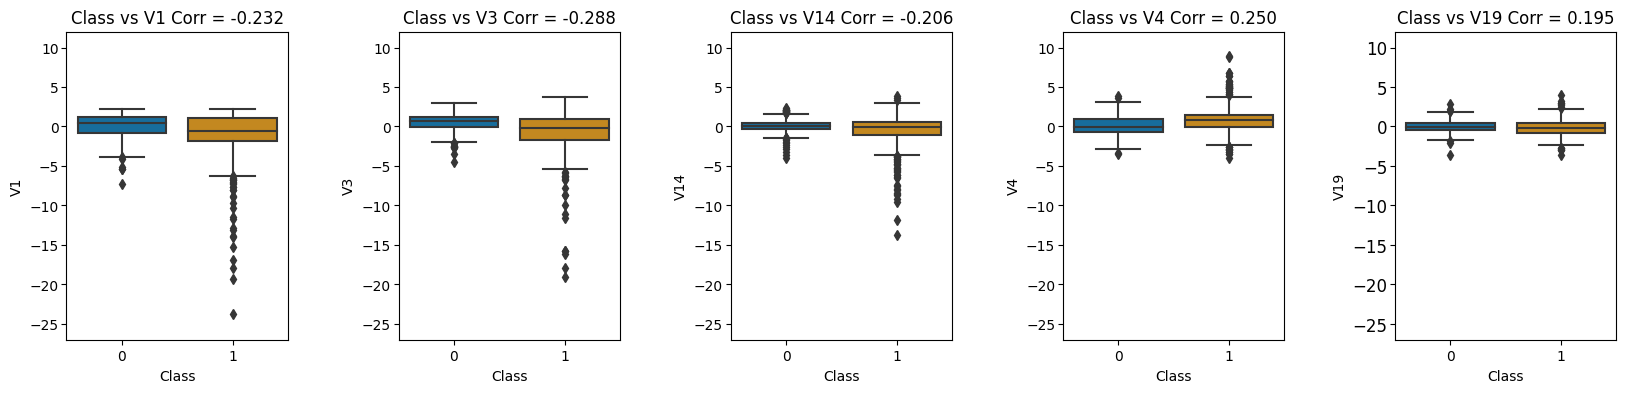

In [16]:
# Calculate the correlations between features and target variable
corr_matrix_b = undersample_train_data.corrwith(undersample_train_data['Class'])

# Create a dataframe of correlations
corr_df = pd.DataFrame(corr_matrix_b, columns=['Correlation Score'])

# Print the dataframe
print("Correlation between features and target variable")
print(corr_df)

# There is some strong negative correlation between Class and V1, V3, V14 and positive with V4.
# Preset plotting area
f, axes = plt.subplots(ncols=5, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V1", data=undersample_train_data, palette="colorblind", ax=axes[0])
axes[0].set_title('Class vs V1 Corr = -0.232')
axes[0].set_ylim([-27, 12])

sns.boxplot(x="Class", y="V3", data=undersample_train_data, palette="colorblind", ax=axes[1])
axes[1].set_title('Class vs V3 Corr = -0.288')
axes[1].set_ylim([-27, 12])

sns.boxplot(x="Class", y="V14", data=undersample_train_data, palette="colorblind", ax=axes[2])
axes[2].set_title('Class vs V14 Corr = -0.206')
axes[2].set_ylim([-27, 12])

sns.boxplot(x="Class", y="V4", data=undersample_train_data, palette="colorblind", ax=axes[3])
axes[3].set_title('Class vs V4 Corr = 0.250')
axes[3].set_ylim([-27, 12])

sns.boxplot(x="Class", y="V19", data=undersample_train_data, palette="colorblind", ax=axes[4])
axes[4].set_title('Class vs V19 Corr = 0.195')
axes[4].set_ylim([-27, 12])

# Adjust the plotting
plt.yticks(fontsize=12)
plt.subplots_adjust(wspace=0.5)
for ax in axes:
    ax.tick_params(axis='y', pad=2)

### Balanced Subsample Dataset - Synthetic Minority Oversampling Technique
Undersampling is not the preferred method as it removes so much of data that could have been used to train the model. Oversampling is less than ideal as it can cause model overfitting. Synthetic Minority Oversampling TEchnique (SMOTE) on the other had, up-samples the minority class while avoiding overfitting. It does so by generating a subset of new synthetic examples that are close to the other same class points.

In [17]:
# Split the original training data set into explanatory variables and labels
X_train = train_data.drop(['Class'], axis=1)
y_train = train_data['Class']

# Count the number of variables
counter = Counter(y_train)
print('Before oversampling', counter)

# Oversampling the train dataset using SMOTE
smt = SMOTE(sampling_strategy='minority', random_state=42)

# X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)
counter = Counter(y_train_smote)
print('After oversampling', counter)

# Combine the train data with labels
train_smote = pd.concat([pd.DataFrame(X_train_smote), pd.DataFrame(y_train_smote)], axis=1)

Before oversampling Counter({0: 218660, 1: 469})
After oversampling Counter({0: 218660, 1: 218660})


### SMOTE Performance

Recal performance is extremely low.

In [11]:
# Define the pipelines for SMOTE data evaluation
pipeline = ImbPipeline([
    ('sampling', SMOTE(random_state=42)),
    ('model', LogisticRegression())
])

# Split the data into training and testing sets
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Fit the pipeline on the training set
pipeline.fit(X_train_s, y_train_s)

# Make predictions on the testing set
y_pred_s = pipeline.predict(X_test_s)

# Print the classification report
print(classification_report(y_test_s, y_pred_s))

# Compute and print evaluation metrics
acc = accuracy_score(y_test_s, y_pred_s)
prec = precision_score(y_test_s, y_pred_s)
rec = recall_score(y_test_s, y_pred_s)
f1 = f1_score(y_test_s, y_pred_s)
roc_auc = roc_auc_score(y_test_s, y_pred_s)

# Print the evaluation results
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)
print('AUC-ROC score:', roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     65593
           1       0.01      0.53      0.02       146

    accuracy                           0.85     65739
   macro avg       0.50      0.69      0.47     65739
weighted avg       1.00      0.85      0.92     65739

Accuracy: 0.8538006358478224
Precision: 0.008107265357031494
Recall: 0.5342465753424658
F1-score: 0.015972151121122144
AUC-ROC score: 0.6943792448617867


### SMOTE Hyperarameter Tuning

Please refer to these results, as the code took a long time to generate:
Best parameters:  {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'sampling__sampling_strategy': 0.2}
Best score:  0.9856842800194483

In [ ]:
# Define the pipeline
pipeline = ImbPipeline([
    ('sampling', SMOTE(random_state=42)),
    ('model', LogisticRegression())
])

# Define the hyperparameter grid to search over
param_grid = {
    'sampling__sampling_strategy': ['minority', 'not majority', 0.2, 0.4, 0.6, 0.8],
    'model__penalty': ['l1', 'l2'],
    'model__C': [1, 10, 100],
    'model__solver': ['liblinear']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print('Best parameters: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)

# Best parameters:  {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'sampling__sampling_strategy': 0.2}
# Best score:  0.9856842800194483

### SMOTE Performance with Hyperparameters

Recall was improved, but not ENOUGH!!

In [12]:
# Define the pipeline with the best hyperparameters
pipeline = ImbPipeline([
    ('sampling', SMOTE(random_state=42, sampling_strategy=0.2)),
    ('model', LogisticRegression(penalty='l2', C=100, solver='liblinear'))
])

# Split the data into training and testing sets
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Fit the pipeline on the training set
pipeline.fit(X_train_s, y_train_s)

# Make predictions on the testing set
y_pred_s = pipeline.predict(X_test_s)

# Print the classification report
print(classification_report(y_test_s, y_pred_s))

# Compute and print evaluation metrics
acc = accuracy_score(y_test_s, y_pred_s)
prec = precision_score(y_test_s, y_pred_s)
rec = recall_score(y_test_s, y_pred_s)
f1 = f1_score(y_test_s, y_pred_s)
roc_auc = roc_auc_score(y_test_s, y_pred_s)

# Print the evaluation results
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1-score:', f1)
print('AUC-ROC score:', roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     65593
           1       0.00      0.01      0.01       146

    accuracy                           0.99     65739
   macro avg       0.50      0.50      0.50     65739
weighted avg       1.00      0.99      0.99     65739

Accuracy: 0.9891997140205966
Precision: 0.0035211267605633804
Recall: 0.0136986301369863
F1-score: 0.005602240896358544
AUC-ROC score: 0.5025348302911542


### Correlation in Balanced SMOTE data

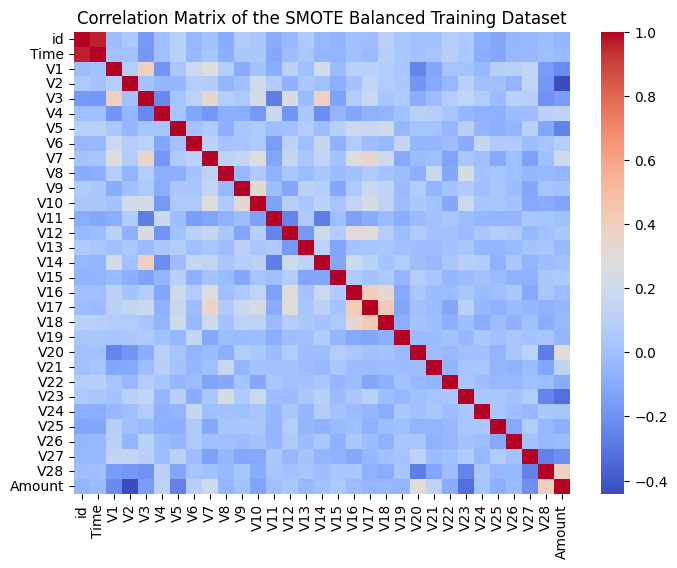

Variables with absolute correlation of 0.35 or higher:
    Variable 1 Variable 2  Correlation Score
32        Time         id           0.961682
33         V17        V18           0.424720
36         V16        V17           0.419664
38          V1         V3           0.395105
39         V14         V3           0.391920
41      Amount        V28           0.391723
44         V17         V7           0.352089
960     Amount         V2           0.441264


In [17]:
# Calculate the correlations between features
corr_matrix_b = X_train_smote.corr()
# Visualise the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_b, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of the SMOTE Balanced Training Dataset')
plt.show()

# Find the absolute correlations that are 0.35 or higher
high_corr_vars = pd.DataFrame(np.abs(corr_matrix_b.unstack().sort_values(ascending=False)), columns=['Correlation Score']).reset_index()
high_corr_vars.columns = ['Variable 1', 'Variable 2', 'Correlation Score']
high_corr_vars = high_corr_vars[high_corr_vars['Correlation Score'] >= 0.35]
high_corr_vars = high_corr_vars[high_corr_vars['Variable 1'] < high_corr_vars['Variable 2']]

# Print the variables with high correlation
print("Variables with absolute correlation of 0.35 or higher:")
print(high_corr_vars)

### Training and Testing Data

### Data Scaling
Once splitting our undersampled balanced training data into a test train split, we decided to scale the data using RobustScaler(). Although the data had already been PCA transformed, we do not know if it has been scaled before or not due to confidentiality issues. If the data was not scaled before performing PCA, it may be benefitial to scale the principle components after. We experimented with only scaling the columns 'amount' and 'time' (the variables that hadn't been PCA transformed) and we achieved worsened results. For this reason we decided to scale all of the variables.

In [18]:
# Define a function to split and scale data
def split_and_scale_data(df):
    X = df.drop(['Class', 'id'], axis=1)
    y = df['Class']

    # Scale the data using RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(undersample_train_data)


### Model Fitting

We decided to test the 5 following models

In [19]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42 , solver = 'liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'KNearest': KNeighborsClassifier()
}

### Model Evaluation
To give a good indication of what models would be best out of our 5, we trained and evaluated our models without altering the hyperparemeters using 5 fold cross validation. We then compared the Mean ROC AUC score from this cross validation with our test set. We see evidence that the Logistic regression, Random Forest and Support Vector Machine models of giving the best fit. 

In [20]:
# Train and evaluate the models using cross-validation
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Evaluate using cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    mean_cv_score = np.mean(cv_scores)
    print(f'{model_name} - Mean ROC AUC (cross-validation): {mean_cv_score}')
    
    # Evaluate the model on the test set
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f'{model_name} - ROC AUC (test set): {test_roc_auc}\n')

Logistic Regression - Mean ROC AUC (cross-validation): 0.7988406317173441
Logistic Regression - ROC AUC (test set): 0.7988525530694206

Decision Tree - Mean ROC AUC (cross-validation): 0.6216306524525702
Decision Tree - ROC AUC (test set): 0.5866322432587493

Random Forest - Mean ROC AUC (cross-validation): 0.782934879681455
Random Forest - ROC AUC (test set): 0.8246127366609295

Support Vector Machine - Mean ROC AUC (cross-validation): 0.8032174256489325
Support Vector Machine - ROC AUC (test set): 0.8307515777395296

KNearest - Mean ROC AUC (cross-validation): 0.7299453052021546
KNearest - ROC AUC (test set): 0.7662650602409639



### Model Evaluation

Grid-Search CV

To test this further, we conducted a grid search of hyperparameters for each of our 5 models to see which permutation of hyperparameters tested achieved the best fitting model.

In [21]:
#Logistic Regression
logisticReg_params = {
    "penalty": ['l1', 'l2'], #Regularization, helps prevent overfitting
    'C': [0.01, 0.1, 1, 10] #controls the strength of regularization penalty, smaller value -> stronger regularization (help prevent overfitting)
}
gridSearch_logisticReg = GridSearchCV(LogisticRegression(solver = 'liblinear'), logisticReg_params)
gridSearch_logisticReg.fit(X_train_scaled, y_train)
#Get the best parameter
logisticReg_bestParam = gridSearch_logisticReg.best_estimator_

#DecisionTree Classifier
DT_params = {
    "criterion": ["gini", "entropy"], #Measure the quality of split
    "max_depth": list(range(2,4,1)), #Max depth of Decision Tree, start from 2, ending at 4 (excluding 4) with a step of 1
    "min_samples_leaf": list(range(5,7,1)) #Min num of samples required to be at a leaf node.
    }
gridSearch_DT = GridSearchCV(DecisionTreeClassifier(), DT_params)
gridSearch_DT.fit(X_train_scaled, y_train)
#Get the best parameter
DT_bestParam = gridSearch_DT.best_estimator_

#Random Forest Classifier
RF_params = {
    "criterion": ["gini", "entropy"], #Measure the quality of split
    "max_depth": list(range(2,4,1)), #Max depth of Decision Tree, start from 2, ending at 4 (excluding 4) with a step of 1
    "min_samples_leaf": list(range(5,7,1)) #Min num of samples required to be at a leaf node.
}
gridSearch_RF = GridSearchCV(RandomForestClassifier(), RF_params)
gridSearch_RF.fit(X_train_scaled, y_train)
#Get the best parameter
RF_bestParam = gridSearch_RF.best_estimator_

#Support Vector Machine
SVC_params = {
    'C': [0.5, 0.7, 0.9, 1], #control the penalty for misclassification, smaller value -> wider margin (thus simpler model), and vice versa.
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'] #transform the data into a higher-dimensional space
}
gridSearch_SVC = GridSearchCV(SVC(), SVC_params)
gridSearch_SVC.fit(X_train_scaled, y_train)
#Get the best parameter
SVC_bestParam = gridSearch_SVC.best_estimator_

#KNears best estimator
kNears_params = {
    "n_neighbors": list(range(2,5,1)), 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
gridSearch_KNears = GridSearchCV(KNeighborsClassifier(), kNears_params)
gridSearch_KNears.fit(X_train_scaled, y_train)
#Get the best estimator
KNears_bestParam = gridSearch_KNears.best_estimator_

We see the 3 models that we mentioned before, namely Logistic Regression, Random Forest and SVC, all continue to perform well with a slight indication that the Logistic Regression model may be best.

In [22]:
#Cross validation score of each method
bestParam_list = [logisticReg_bestParam, DT_bestParam, RF_bestParam, SVC_bestParam, KNears_bestParam]
Name_list = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Machine', 'KNearest']

for i, j in zip(Name_list, bestParam_list):
    score = cross_val_score(j, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f'{i} - GridSearch CV Score: {score.mean()}')

Logistic Regression - GridSearch CV Score: 0.799267095157506
Decision Tree - GridSearch CV Score: 0.6434697722368956
Random Forest - GridSearch CV Score: 0.7711578692743076
Support Vector Machine - GridSearch CV Score: 0.7884147435517299
KNearest - GridSearch CV Score: 0.713307912280515


To test this further, we decided to plot the learning curves for all 5 of our estimators. 

In [23]:
X_train_reset_ID = undersample_train_data.reset_index(drop=True)
names = X_train_reset_ID.drop('Class', axis=1)
features = names.columns.to_list()

Plot the learning curve for each model

In [24]:
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, estimator5, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Random Forest Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    
    # Fifth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator5, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax5.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax5.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax5.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax5.set_xlabel('Training size (m)')
    ax5.set_ylabel('Score')
    ax5.grid(True)
    ax5.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/home/lmw24/.local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

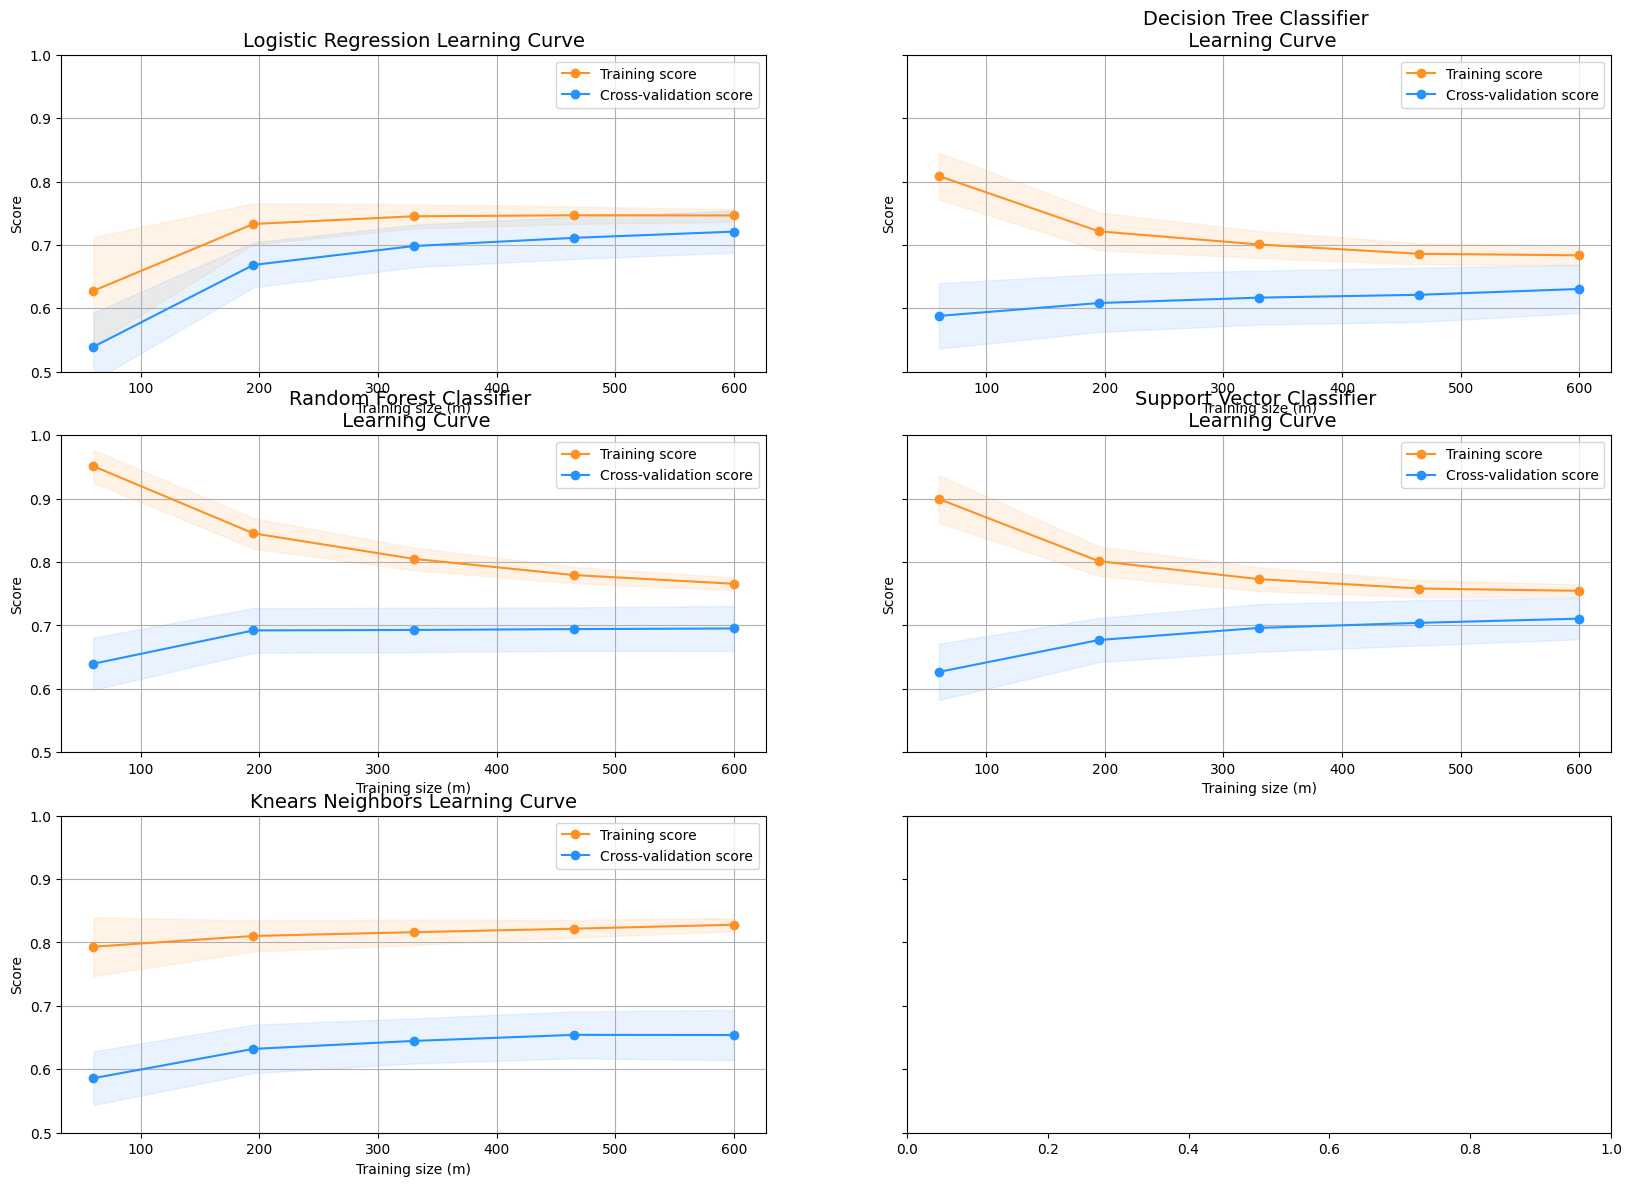

In [25]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(logisticReg_bestParam, DT_bestParam, RF_bestParam, SVC_bestParam, KNears_bestParam, X_train_scaled, y_train, (0.5, 1.0), cv=cv, n_jobs=4)

Plot ROC Curve

Now we plot the ROC curve for each of our 5 estimators. We conduct 5 fold cross validation predictions and then compare these to the labels of our training data.

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
#Logistic Regression
LR_pred = cross_val_predict(logisticReg_bestParam, X_train_scaled, y_train, cv=5, method="decision_function")

#Decision Tree
DT_pred = cross_val_predict(DT_bestParam, X_train_scaled, y_train, cv=5)

#Random Forest
RF_pred = cross_val_predict(RF_bestParam, X_train_scaled, y_train, cv=5)

#Support Vector Machine
SVC_pred = cross_val_predict(SVC_bestParam, X_train_scaled, y_train, cv=5, method="decision_function")

#kNearest
kNears_pred = cross_val_predict(KNears_bestParam, X_train_scaled, y_train, cv=5)

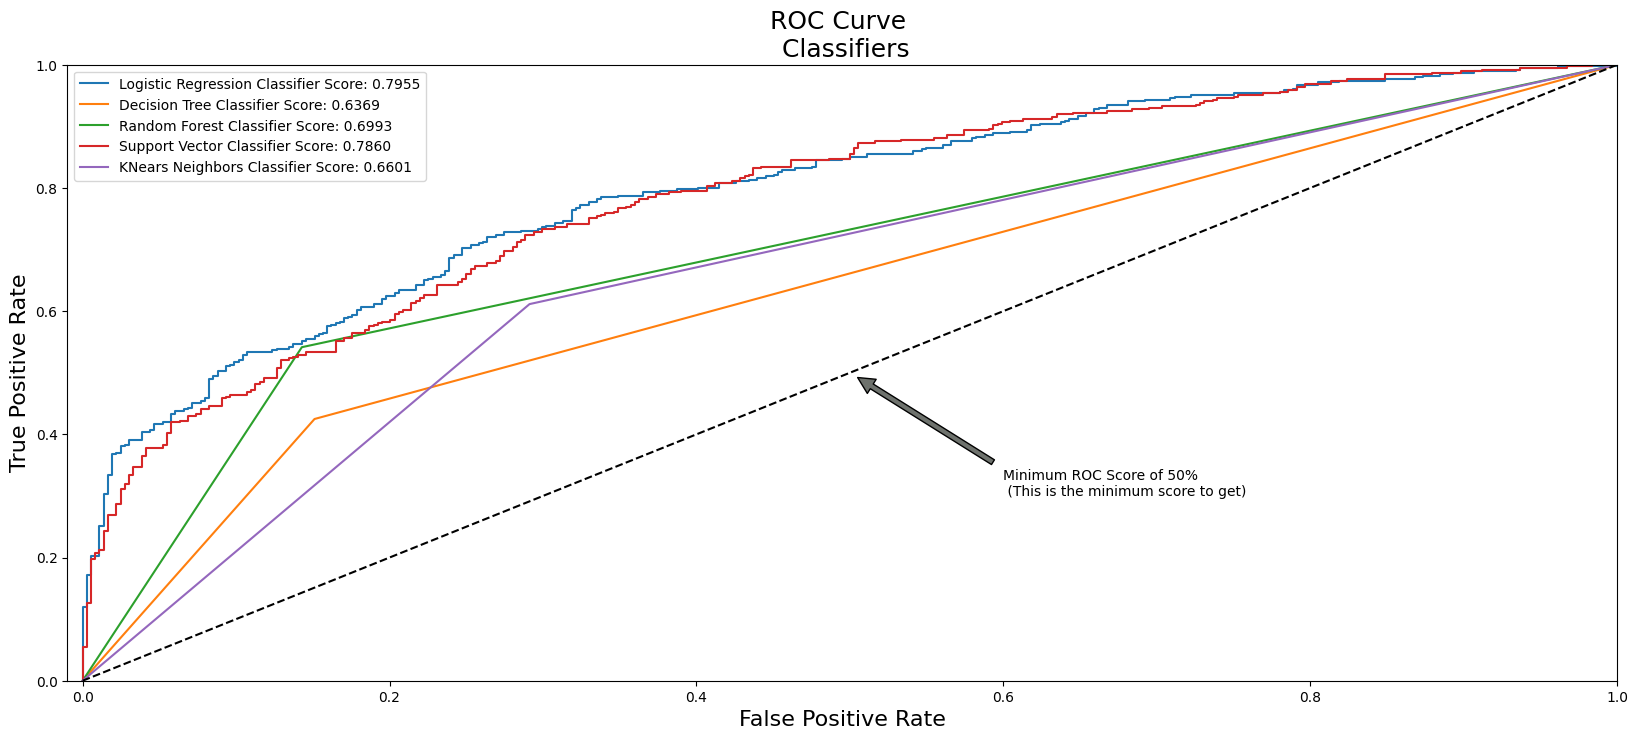

In [27]:
#fpr: False Positive Rate
#tpr: True Positive Rate

LR_fpr, LR_tpr, LR_threshold = roc_curve(y_train, LR_pred)
DT_fpr, DT_tpr, DT_threshold = roc_curve(y_train, DT_pred)
RF_fpr, RF_tpr, RF_threshold = roc_curve(y_train, RF_pred)
SVC_fpr, SVC_tpr, SVC_threshold = roc_curve(y_train, SVC_pred)
kNears_fpr, kNears_tpr, kNears_threshold = roc_curve(y_train, kNears_pred)

def plot_multiple_roc_graphs(LR_fpr, LR_tpr, DT_fpr, DT_tpr, RF_fpr, RF_tpr, SVC_fpr, SVC_tpr, kNears_fpr, kNears_tpr):
    plt.figure(figsize=(20,8))
    plt.title('ROC Curve \n Classifiers', fontsize=18)
    plt.plot(LR_fpr, LR_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, LR_pred)))
    plt.plot(DT_fpr, DT_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, DT_pred)))
    plt.plot(RF_fpr, RF_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, RF_pred)))
    plt.plot(SVC_fpr, SVC_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, SVC_pred)))
    plt.plot(kNears_fpr, kNears_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, kNears_pred)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

plot_multiple_roc_graphs(LR_fpr, LR_tpr, DT_fpr, DT_tpr, RF_fpr, RF_tpr, SVC_fpr, SVC_tpr, kNears_fpr, kNears_tpr)
plt.show()

We see from the ROC plots that SVC and Logistic Regression give the best curves on the training data with the best score achieved by the Logistic Regression model. Lets look at the closer.

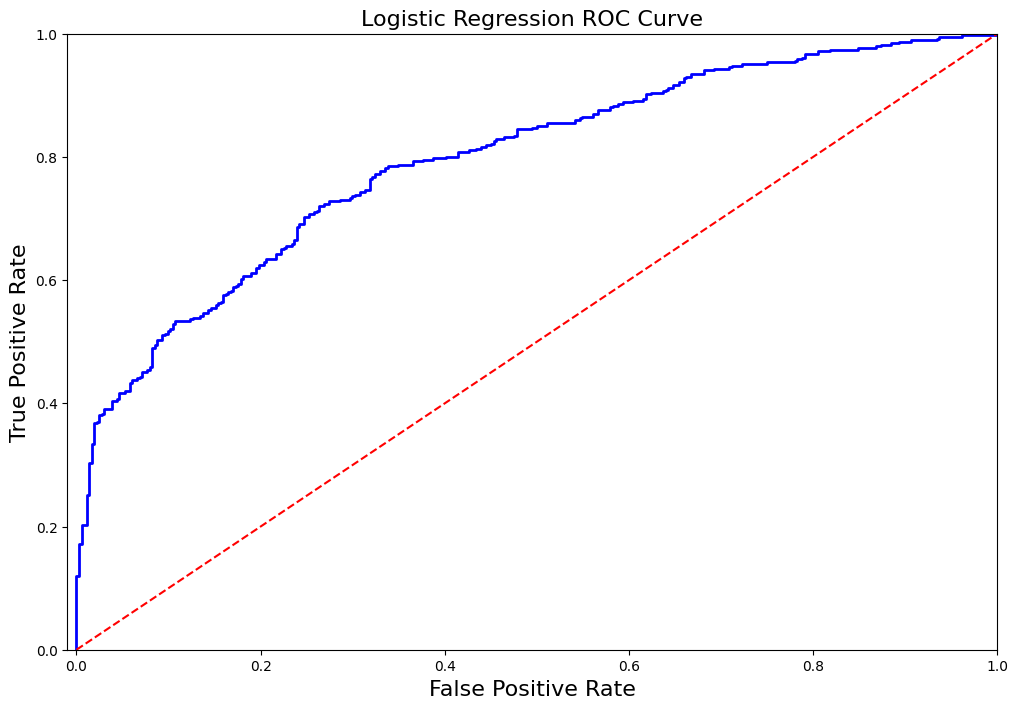

In [28]:
def LR_roc_curve(LR_fpr, LR_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(LR_fpr, LR_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
LR_roc_curve(LR_fpr, LR_tpr)
plt.show()

We then took a look at the Recall Precision, F1 and Accuracy scores for our Logistic Regression model.

In [29]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = logisticReg_bestParam.predict(X_train_scaled)

print('---' * 45)
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Recall Score: 0.73
Precision Score: 0.77
F1 Score: 0.75
Accuracy Score: 0.75
---------------------------------------------------------------------------------------------------------------------------------------


Finally, we decided to look at how the Logistic Regression model's confusion matrix compared to that of our estimators and the latent distribution of fraudulant and genuine transactions in our test set of our balanced subsample. We see that the Logistic Regression model predicts 55 transactions to the wrong class which is the lowest amount of our 5 models providing extra evidence to the fact that it is our best model.

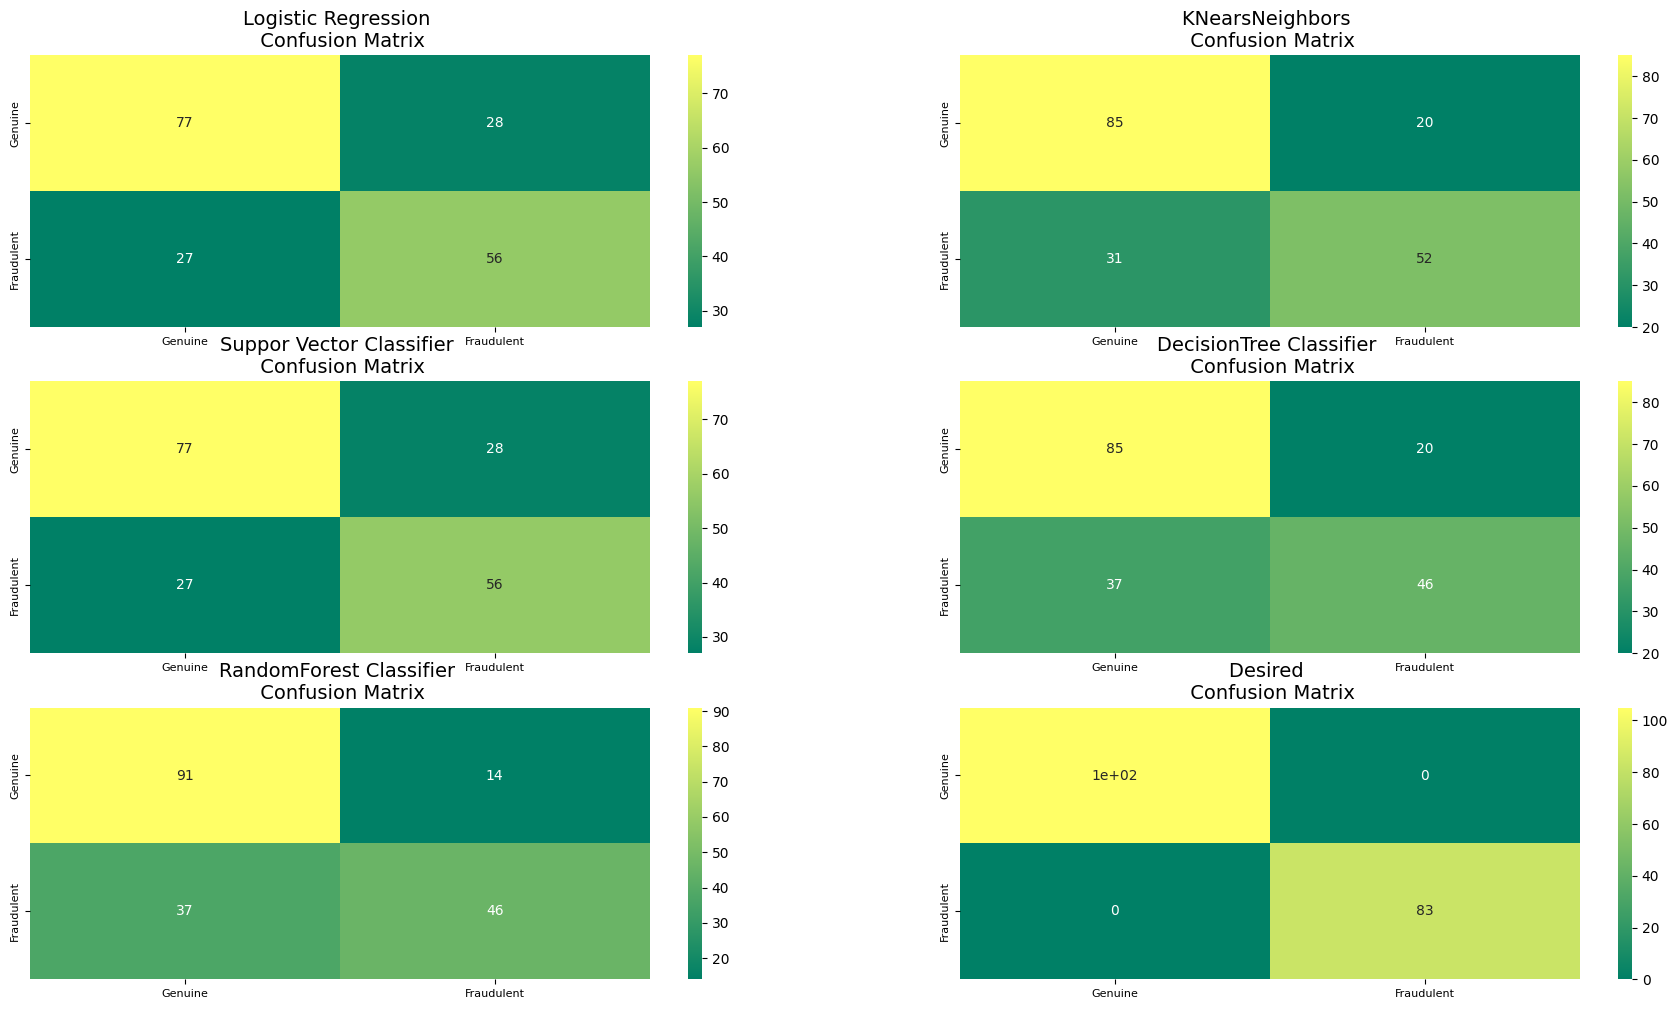

In [30]:
# Predictions using our 5 classifiers
y_pred_lr = logisticReg_bestParam.predict(X_test_scaled)
y_pred_knear = KNears_bestParam.predict(X_test_scaled) 
y_pred_svc = SVC_bestParam.predict(X_test_scaled)
y_pred_tree = DT_bestParam.predict(X_test_scaled) 
y_pred_rf = RF_bestParam.predict(X_test_scaled)

log_reg_cf = confusion_matrix(y_test, y_pred_lr)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)
rf_cf = confusion_matrix(y_test, y_pred_rf)
test_cf = confusion_matrix(y_test , y_test)

fig, ax = plt.subplots(3, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.summer)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=0)
ax[0, 0].set_yticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=90)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.summer)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=0)
ax[0][1].set_yticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=90)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.summer)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=0)
ax[1][0].set_yticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=90)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.summer)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=0)
ax[1][1].set_yticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=90)

sns.heatmap(rf_cf, ax=ax[2][0], annot=True, cmap=plt.cm.summer)
ax[2][0].set_title("RandomForest Classifier \n Confusion Matrix", fontsize=14)
ax[2][0].set_xticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=0)
ax[2][0].set_yticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=90)

sns.heatmap(test_cf, ax=ax[2][1], annot=True, cmap=plt.cm.summer)
ax[2][1].set_title("Desired \n Confusion Matrix", fontsize=14)
ax[2][1].set_xticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=0)
ax[2][1].set_yticklabels(['Genuine', 'Fraudulent'], fontsize=8, rotation=90)

plt.show()

### Test Data

After training the model with train data, we will now fit the model with test data. 

In [32]:
# Uses standard scaler as we want test on same scale
scaler = StandardScaler()

# Drop 'id' column from test data and scale using StandarScaler
X_test_sc = scaler.fit_transform(test_data.drop('id', axis=1))

# Make dataframe
X_test_sc_df = pd.DataFrame(X_test_sc, columns=test_data.drop('id', axis=1).columns)

put the test data to the best fitted model

In [33]:
# Perform prediction using best model
#SVC_predict = SVC_bestParam.predict(X_test_sc_df)
#print(SVC_predict)
logisticReg_bestParam
FinalLR_predict = logisticReg_bestParam.predict_proba(X_test_sc_df)[:,1]

In [34]:
test_sub = pd.DataFrame()
test_sub['id'] = test_data['id']
test_sub['Class'] = pd.DataFrame(FinalLR_predict, columns=['Class'])
print(test_sub)
test_sub.to_csv('test_submission_FinalLRBestParam.csv', index=False)

            id     Class
0       219129  0.473057
1       219130  0.427911
2       219131  0.333024
3       219132  0.584830
4       219133  0.401502
...        ...       ...
146082  365211  0.429175
146083  365212  0.484118
146084  365213  0.610784
146085  365214  0.120257
146086  365215  0.264037

[146087 rows x 2 columns]


After submitting the test_submission.csv to Kaggle, we got a private score of 0.77557 and a public of 0.81649

![Scores](FinalLR.png)

### Imputated Data Testing
We carried out the same process as before to train the model, however we only used our best model (Logistic Regression), we then compared the results

In [17]:
# Define the imputation methods
imputation_methods = {
    'Mean Imputation': SimpleImputer(strategy='mean'),
    'Iterative Imputer': IterativeImputer(random_state=42),
    'KNN Imputation': KNNImputer(n_neighbors=6),
}

# Assign object for data
imputed_data_dfs = {}

# Create Imputed Data
for method_name, imputer in imputation_methods.items():
    imputed_data = imputer.fit_transform(train_data_missing)
    imputed_data_df = pd.DataFrame(imputed_data, columns=train_data_missing.columns)
    imputed_data_dfs[method_name] = imputed_data_df

# Assign the imputed data respectively
mean_train = imputed_data_dfs['Mean Imputation']
iterative_train = imputed_data_dfs['Iterative Imputer']
KNN_train = imputed_data_dfs['KNN Imputation']

In [35]:
# Apply random undersampling to each imputed dataframe
mean_train_balanced = random_undersample(mean_train)
iterative_train_balanced = random_undersample(iterative_train)
KNN_train_balanced = random_undersample(KNN_train)
train_balanced = random_undersample(train_data)

In [36]:
# Define a function to split and scale data
def split_and_scale_data(df):
    X = df.drop(['Class', 'id'], axis=1)
    y = df['Class']

    # Scale the data using RobustScaler
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Scale and split into X and y
mean_X_train, mean_X_test, mean_y_train, mean_y_test = split_and_scale_data(mean_train_balanced)
iterative_X_train, iterative_X_test, iterative_y_train, iterative_y_test = split_and_scale_data(iterative_train_balanced)
KNN_X_train, KNN_X_test, KNN_y_train, KNN_y_test = split_and_scale_data(KNN_train_balanced)
X_train, X_test, y_train, y_test = split_and_scale_data(train_balanced)

# Uses standard scaler as we want test on same scale
scaler = StandardScaler()

# Drop 'id' column from test data and scale using StandarScaler
X_test_sc = scaler.fit_transform(test_data.drop('id', axis=1))

# Make dataframe
X_test_sc_df = pd.DataFrame(X_test_sc, columns=test_data.drop('id', axis=1).columns)

In [45]:
# Define a function for fitting the Logistic Regression model with the best parameters
def fit_LR(X_train, y_train):
    logisticReg_params = {
        "penalty": ['l1', 'l2'],  # Regularization, helps prevent overfitting
        'C': [0.01, 0.1, 1, 10]  # Controls the strength of regularization penalty, smaller value -> stronger regularization (help prevent overfitting)
    }
    gridSearch_logisticReg = GridSearchCV(LogisticRegression(solver='liblinear'), logisticReg_params)
    gridSearch_logisticReg.fit(X_train, y_train)
    best_LR_model = gridSearch_logisticReg.best_estimator_
    return best_LR_model

# Fit the split data to a Logistic Regression model with the best parameters for each imputed dataset
mean_LR_model = fit_LR(mean_X_train, mean_y_train)
iterative_LR_model = fit_LR(iterative_X_train, iterative_y_train)
KNN_LR_model = fit_LR(KNN_X_train, KNN_y_train)
normal_LR_model = fit_LR(X_train, y_train)

In [51]:
# Make predictions using the trained models
mean_y_pred = mean_LR_model.predict_proba(mean_X_test)[:,1]
iterative_y_pred = iterative_LR_model.predict_proba(iterative_X_test)[:,1]
KNN_y_pred = KNN_LR_model.predict_proba(KNN_X_test)[:,1]
normal_y_pred = normal_LR_model.predict_proba(X_test)[:,1]

In [52]:
# Calculate ROC AUC scores
mean_roc_auc = roc_auc_score(mean_y_test, mean_y_pred)
iterative_roc_auc = roc_auc_score(iterative_y_test, iterative_y_pred)
KNN_roc_auc = roc_auc_score(KNN_y_test, KNN_y_pred)
normal_roc_auc = roc_auc_score(y_test, normal_y_pred)

# Print ROC AUC scores
print("Mean Imputation SVC Model ROC AUC Score:", mean_roc_auc)
print("Iterative Imputation SVC Model ROC AUC Score:", iterative_roc_auc)
print("KNN Imputation SVC Model ROC AUC Score:", KNN_roc_auc)
print("Normal SVC Model ROC AUC Score:", normal_roc_auc)

# Calculate percentage differences
mean_difference = ((mean_roc_auc - normal_roc_auc) / normal_roc_auc) * 100
iterative_difference = ((iterative_roc_auc - normal_roc_auc) / normal_roc_auc) * 100
KNN_difference = ((KNN_roc_auc - normal_roc_auc) / normal_roc_auc) * 100

# Print percentage differences
print("\nPercentage difference between Mean Imputation and Normal ROC AUC Score: {:.2f}%".format(mean_difference))
print("Percentage difference between Iterative Imputation and Normal ROC AUC Score: {:.2f}%".format(iterative_difference))
print("Percentage difference between KNN Imputation and Normal ROC AUC Score: {:.2f}%".format(KNN_difference))

Mean Imputation SVC Model ROC AUC Score: 0.7870338496844521
Iterative Imputation SVC Model ROC AUC Score: 0.8044750430292599
KNN Imputation SVC Model ROC AUC Score: 0.8091795754446357
Normal SVC Model ROC AUC Score: 0.8012621916236374

Percentage difference between Mean Imputation and Normal ROC AUC Score: -1.78%
Percentage difference between Iterative Imputation and Normal ROC AUC Score: 0.40%
Percentage difference between KNN Imputation and Normal ROC AUC Score: 0.99%


In [57]:
iterative_y_pred_test = iterative_LR_model.predict_proba(X_test_sc_df)[:,1]

In [58]:
test_iter = pd.DataFrame()
test_iter['id'] = test_data['id']
test_iter['Class'] = pd.DataFrame(iterative_y_pred_test, columns=['Class'])
print(test_iter)
test_iter.to_csv('test_submission_iterative.csv', index=False)

            id     Class
0       219129  0.465380
1       219130  0.392403
2       219131  0.275122
3       219132  0.628337
4       219133  0.410281
...        ...       ...
146082  365211  0.319381
146083  365212  0.422518
146084  365213  0.634240
146085  365214  0.046574
146086  365215  0.246808

[146087 rows x 2 columns]
